### Including setup_base params in this notebook
### optimization in pytorch

In [1]:
import numpy as np
import json
import sys
import torch
from torch import optim
from lib.defaults import Main
from lib.gramians import Make
from lib.dynamics_diff import Dynamics
from lib.plotting import plot_out

In [2]:
main = Main()
G = Make(main.a)

# setup_base
target = torch.load("./velocity.pt")  #(c,2,t)
n_mov = len(target)
n_muscles, n_bins = np.array(target[0]).shape
xstars_std = 0.2
t_max = main.sampling_dt * n_bins

# prms
n = main.n
n_obs = 50   # actually n, but 50 has good result
n_e = main.n_e
lambda_traj = 1.0 / n_mov
lambda_reg = 1.0 / (len(main.m1_slice) * n_muscles)

gamma_ = torch.Tensor(main.gamma)
reuse = False 

In [3]:
# Spontaneous
np.random.seed(2021)
spontaneous = (
    np.loadtxt('spontaneous.txt') if reuse
    else         
        (np.random.normal(0, main.spontaneous_std, (n,1))+ main.baseline_rate)   # in accordance with paper
)

xstars_prms0 = np.random.normal(scale=0.1 / np.sqrt(n), size=(n_obs, n_mov))
c_prms0 = np.random.normal(scale=0.1 / np.sqrt(n), size=(n_muscles, n_e))
xstars_p_tch = torch.Tensor(xstars_prms0).requires_grad_(True)
c_p_tch = torch.Tensor(c_prms0).requires_grad_(True)   
# torch
spontaneous_ = torch.Tensor(spontaneous)

In [4]:
def unpack(xstars_prms, c):
    # xstars_prms: n_obs * n_mov
    # c_prms: n_muscles * n_m1

    # Get the top n_obs eigenvectors of the observability Gramian
    top_obs = torch.Tensor(G.O.top(n_obs))
    z = n * n_mov * xstars_std ** 2

    # Calculate xstars and c
    xstars = top_obs @ xstars_prms
    xstars = torch.sqrt(z / torch.sum(xstars ** 2)) * xstars 
    xstars_motor = gamma_ @ torch.cat((xstars + spontaneous_, spontaneous_), axis=1) # no gamma
    h = torch.linalg.solve(xstars_motor.T @ xstars_motor, xstars_motor.T)
    c = c - c @ xstars_motor @ h

    return spontaneous_ + xstars, c


In [5]:
# Trajectory
def trajectory(xstar, c):    
    r = Dynamics().run(t_max, xstar, spontaneous_, grad = True)
    r = torch.stack(r, dim=0)  
    out = [c @ gamma_ @ r[:,:,i].T for i in range(n_mov)]
    out = torch.stack(out, dim=0) 
    return r, out

In [6]:
def loss(vel, target, c):
    cost_move = lambda_traj * main.sampling_dt * ((vel - target)**2).sum()
    reg = lambda_reg * (c ** 2).sum()
    return cost_move + reg

In [11]:
n_iter = 500 
    # torch  
updater = optim.Adam([xstars_p_tch, c_p_tch])  

for it in range(n_iter):          
    xstars, c = unpack(xstars_p_tch, c_p_tch)
    _, vel = trajectory(xstars, c)        
    l = loss(vel, target, c)
    updater.zero_grad()
    l.backward()
    updater.step()
    sys.stdout.write(f'\r iteration {it+1}/{n_iter} | train loss: {l.item():.5f}')
    sys.stdout.flush()

 iteration 457/500 | train loss: 0.00017

KeyboardInterrupt: 

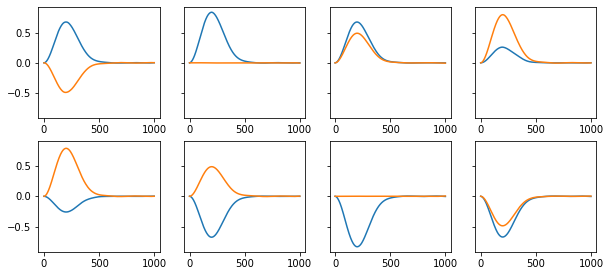

In [12]:
_, vel = trajectory(xstars, c)  
plot_out(vel.detach().numpy())

In [13]:
prms = {
        'xstars': xstars.detach().numpy().tolist(),
        'c': c.detach().numpy().tolist()
}
with open("setup_prms.json","w", encoding='utf-8') as f: 
    f.write(  json.dumps(  prms  ,ensure_ascii=False  ) )  
np.savetxt('spontaneous.txt',spontaneous)